In [ ]:
# pip install --upgrade plotly 

# Libraries and Drive

Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
main_path = "/content/drive/MyDrive/Dipak/Internship/Technocolab/data/Twitter"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import os
import re as re
import nltk
from nltk.tokenize import TweetTokenizer
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('vader_lexicon')
from scipy import sparse
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



In [ ]:
os.chdir(main_path)
os.getcwd()

'/content/drive/MyDrive/Dipak/Internship/Technocolab/data/Twitter'

# **Dataset**

### Twitter dataset loading

In [ ]:
main_path = "/content/drive/MyDrive/Dipak/Internship/Technocolab/data/Twitter"
os.chdir(main_path)
os.getcwd()
df = pd.DataFrame()
for current_dir, dirs, files in os.walk('.'):
  for f in files:
    print(f)
    if f.endswith('.csv'):
      data = pd.read_csv(f, header=0, error_bad_lines=False, encoding='utf-8')
      data["Stockname"] = f[:-4]
      df = df.append(data, ignore_index=True)

AAPL.csv
MSFT.csv
NVDA.csv
PYPL.csv
TSLA.csv
wordcloud11.png


In [ ]:
df.head()

,Datetime,Text,Stockname
0,2021-09-20 23:15:03+00:00,"@MacRumors @julipuli Now, if only any of us ou...",AAPL
1,2021-09-20 22:15:53+00:00,"Apple Inc price at close, 2021-09-20, is 142.9...",AAPL
2,2021-09-20 22:10:27+00:00,AAPL 20210917 Weekly Price Pattern Coordinates...,AAPL
3,2021-09-20 20:57:29+00:00,#SDC leads today #reddit #wallstreetbets. Stoc...,AAPL
4,2021-09-20 20:32:57+00:00,Is Apple's stock...\n\n$AAPL #AAPL\n🗞️👉https:/...,AAPL


In [ ]:
# This function will spilt datetime column in date and time, and drop datetime and time column at the end.

def split_date_time(series):
  L1=[]
  L2=[]
  for i in range(len(series)):
    date, time = df["Datetime"][i].split(' ')
    L1.append(date)
    L2.append(time)
  df_1 = pd.DataFrame()
  df_1["Date"] = L1
  df_1["Time"] = L2
  return df_1
df_1=split_date_time(df["Datetime"])
df = df.merge(df_1, right_index=True, left_index=True)
df.drop('Datetime', axis=1, inplace=True)
df.drop('Time', axis=1, inplace=True)
# df.index = df["Date"]
# df.drop('Date', axis=1, inplace=True)

### Stock dataset loading

In [ ]:
main_path = "/content/drive/MyDrive/Dipak/Internship/Technocolab/data/Stock"
os.chdir(main_path)
df1 = pd.DataFrame()

for current_dir, dirs, files in os.walk('.'):
  for f in files:
    if f.endswith('.csv'):
      data = pd.read_csv(f, header=0, error_bad_lines=False, encoding='utf-8')
      # data.Date=pd.to_datetime(data["Date"])
      data = data.sort_values(["Date"])
      data["Stockname"] = f[:-4]
      # 'df_'+str(i) = data 
      
      df1 = df1.append(data, ignore_index=True)
for i in range(df1.shape[0]):
  if '/' in df1.iloc[i,0]:
    df1.iloc[i,0] = df1.iloc[i,0].replace('/','-')
month=[]
year=[]
day=[]
L=[]
for i in range(df1.shape[0]):
  
  if '-' in df1.iloc[i, 0]:
    month.append(str(df1.iloc[i,0]).split(' ')[0].split('-')[1])
    day.append(str(df1.iloc[i,0]).split(' ')[0].split('-')[0])
    year.append(str(df1.iloc[i,0]).split(' ')[0].split('-')[2])
  elif '/' in df1.iloc[i, 0]:
    month.append(str(df1.iloc[i,0]).split(' ')[0].split('/')[1])
    day.append(str(df1.iloc[i,0]).split(' ')[0].split('/')[0])
    year.append(str(df1.iloc[i,0]).split(' ')[0].split('/')[2])
    

df1["Day"] = day
df1["Month"] = month
df1["Year"] = year 
df1 = df1.sort_values(["Year","Month","Day"])

# Data Preprocessing 

In [ ]:
# This function will clean data, i.e. removes URL, Username, \n etc...

def pre_process(df):
  column=df["Text"]
  

  column = column.str.lower()                                                       # Lower Case
  column = column.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))                 # URL links
  column = column.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))       # URL Links
  column = column.apply(lambda x: re.sub(r'{link}', '', x))                         # Placeholders
  column = column.apply(lambda x: re.sub(r"\[video\]", '', x))                      # Placeholders
  column = column.apply(lambda x: re.sub(r'&[a-z]+;', '', x))                       # HTML Functions
  column = column.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))      # Non Letters
  column = column.apply(lambda x: re.sub(r'@mention', '', x))                       # Mentions
  column = column.apply(lambda x: re.sub(r'\n', '', x))                             # \n
  column = column.apply(lambda x: re.sub(r'-', '', x))                              # -
  column = column.apply(lambda x: re.sub(r'(\s)#\w+', '', x))                       # remove word starting from hashtag

  

  
  return column
column=pre_process(df)
df["clean_text"] = column

Common Words in Tweets.

###### Horizontal Bar

In [ ]:

df['temp_list'] = df['clean_text'].apply(lambda x : str(x).split())
temp = Counter(item for sublist in df['temp_list'] for item in sublist)
top = pd.DataFrame(temp.most_common(20))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common words in Selected Text', orientation='h', width=700, height=700, color='Common_words')
fig.show()

   Common_words  count
0           the  70837
1            to  51043
2           and  39947
3             a  39106
4           for  32375
5            in  31287
6            is  30981
7            of  28865
8            on  23935
9           you  19326
10            i  18396
11         this  17665
12         tsla  17186
13        tesla  15680
14           it  15508
15         with  13843
16           at  12575
17          are  12419
18        stock  11436
19           be  11217


###### Tree Map

In [ ]:

top = Counter(item for sublist in df['temp_list'] for item in sublist)  #If "treemap() got an unexpected keyword argument 'path'" errors occurs then upadate plotly,(1st cell)
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
# print(temp)
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of the most Common Words')
fig.show()


Removing English keywords, i.e. the, or, a, he, she....

In [ ]:
# This code removes unnecessary words using english dictionary
# This code will take approx 6 min

def tokenizer(df):                    
  

  column = df["clean_text"]
  tknzr = TweetTokenizer()
  column = column.apply(tknzr.tokenize)

  PUNCUATION_LIST = list(string.punctuation)
  def remove_punctuation(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCUATION_LIST]
  df['tokens'] = column.apply(remove_punctuation)
  return df

df = tokenizer(df)
nltk.download('stopwords')
import nltk

from nltk.corpus import stopwords
def remove_stopwords(x):
    return [y for y in x if y not in stopwords.words('english')]

df['temp_list1'] = df['tokens'].apply(lambda x : remove_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Horizontal bar plot after removing english words

In [ ]:

# df['temp_list'] = df['tokens'].apply(lambda x : str(x).split())
temp = Counter(item for sublist in df['temp_list1'] for item in sublist)
top = pd.DataFrame(temp.most_common(20))
top.columns = ['Common_words', 'count']
print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common words in Selected Text', orientation='h', width=700, height=700, color='Common_words')
fig.show()

       Common_words  count
0              tsla  18273
1             tesla  16050
2             stock  11748
3             #tsla   9940
4          elonmusk   8693
5              like   7620
6              aapl   7556
7               get   7388
8               buy   6630
9             today   6546
10            chart   6481
11           market   6439
12      wsbchairman   6405
13           reddit   6400
14              plz   6304
15               rt   6190
16  #wallstreetbets   6068
17            price   5963
18              day   5950
19            apple   5781


Tree map

In [ ]:

from nltk.corpus import stopwords as st
from wordcloud import WordCloud
st = set('rt')
st.update(['retweet', 'RT', 'Retweet', 'RETWEET', 'rt', 'plz', 'tsla','tesla','stock','#tsla','elonmusk','apple','#wallstreetbets','reddit','wsbchairman','aapl','#aapl','microsoft'])
def remove_stopwords(x):
    return [y for y in x if y not in st]

df['temp_list1'] = df['temp_list1'].apply(lambda x : remove_stopwords(x))
temp = Counter(item for sublist in df['temp_list1'] for item in sublist)
top = pd.DataFrame(temp.most_common(20))
top.columns = ['Common_words', 'count']
# print(top)
fig = px.bar(top, x='count', y='Common_words', title='Common words in Selected Text', orientation='h', width=700, height=700, color='Common_words')
fig.show()

Word Cloud Image of Most common words

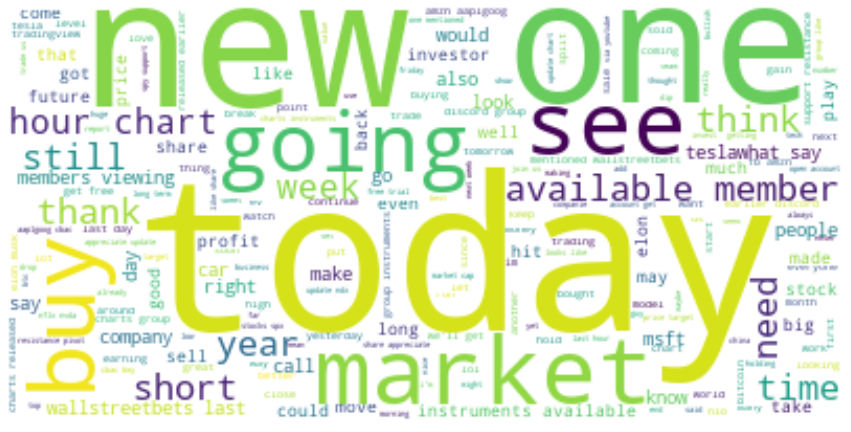

In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
# Create stopword list:
stopwords = set('rt')
stopwords.update(['retweet', 'RT', 'Retweet', 'RETWEET', 'rt', 'plz', 'tsla','tesla','stock','#tsla','elonmusk','apple','#wallstreetbets','reddit','wsbchairman','aapl','#aapl','microsoft'])
l=[]
for i in df.temp_list1:
  t = " ".join(review for review in i)
  l.append(t)
df["temp_list2"] = l
textt = " ".join(review for review in df.temp_list2)
wordcloud = WordCloud(stopwords=stopwords, background_color="White").generate(textt)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

# Sentiment Anaysis on clean data

### Sentiment Intensity Analyzer

In [ ]:
# Sentiment Analyzer will classify sentiments into positive, negative, and neutral
sid = SentimentIntensityAnalyzer()
ss=[]
for k in tqdm(df.temp_list2):
  # print(k)
  ss.append(sid.polarity_scores(k))
neg=[]
pos=[]
neu=[]
compound=[]
for i in tqdm(range(df.temp_list2.shape[0])):
  neg.append(ss[i]["neg"])
  pos.append(ss[i]["pos"])
  neu.append(ss[i]["neu"])
  compound.append(ss[i]["compound"])
sia_table = pd.DataFrame()
sia_table["sia_pos"] = pos
sia_table["sia_neu"] = neu
sia_table["sia_neg"] = neg
sia_table["sia_compound"] = compound
# decide sentiment as positive, negative and neutral
sentiment=[]
for i in ss:
  if i['compound'] >= 0.05 :
    sentiment.append("Positive")

  elif i['compound'] <= - 0.05 :
    sentiment.append("Negative")

  else :
    sentiment.append("Neutral")
df["Sentiment"] = sentiment

neg=0
pos=0
neu=0
pos_count=[]
neg_count=[]
neu_count=[]
if df.Sentiment[0] == 'Positive':
  pos+=1
  pos_count.append(pos)
  neg_count.append(neg) 
  neu_count.append(neu)
elif df.Sentiment[0] == 'Negative':
  neg+=1
  pos_count.append(pos)
  neg_count.append(neg) 
  neu_count.append(neu)
elif df.Sentiment[0] == 'Neutral':
  neu+=1
  pos_count.append(pos)
  neg_count.append(neg) 
  neu_count.append(neu)
for i in range(1,len(df.Date)):   
  if df.Date[i] == df.Date[i-1]:
    if df.Sentiment[i] == 'Positive':
      pos = pos + 1 
      pos_count.append(pos)
      neg_count.append(neg) 
      neu_count.append(neu)
    elif df.Sentiment[i] == 'Negative':
      neg = neg + 1
      neg_count.append(neg)
      pos_count.append(pos)
      neu_count.append(neu)
    elif df.Sentiment[i] == 'Neutral':
      neu = neu + 1
      neu_count.append(neu)
      neg_count.append(neg)
      pos_count.append(pos)
  elif df.Date[i] != df.Date[i-1]:
    neg=0
    pos=0
    neu=0
    if df.Sentiment[i] == 'Positive':
      pos+=1
      pos_count.append(pos)
      neg_count.append(neg) 
      neu_count.append(neu)
    elif df.Sentiment[i] == 'Negative':
      neg+=1
      pos_count.append(pos)
      neg_count.append(neg) 
      neu_count.append(neu)
    elif df.Sentiment[i] == 'Neutral':
      neu+=1
      pos_count.append(pos)
      neg_count.append(neg) 
      neu_count.append(neu)
  
df.pos_count = pos_count
df.neg_count = neg_count
df.neu_count = neu_count


100%|██████████| 134362/134362 [00:00<00:00, 840957.53it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:94: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [ ]:
# df.head()

# **Explaratory Data Analysis**

### Barplot of no of total sentiment stock wise.

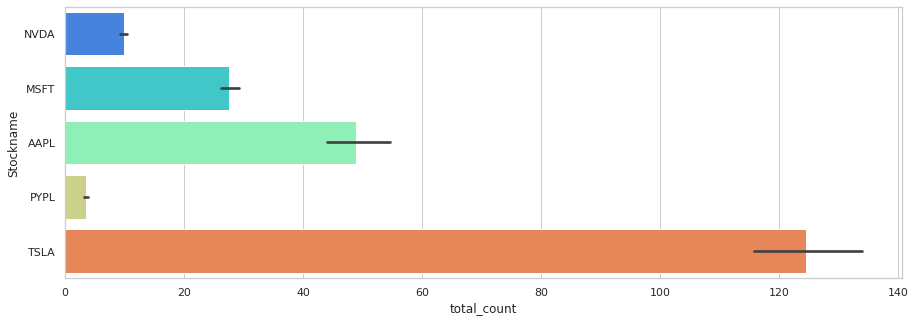

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x="total_count",y="Stockname",data=new_df, orient="h", palette="rainbow", ax=ax)
plt.show()

> Observation : TSLA has the most total sentiment in the twitter dataset. Its because of the TSLA has most number of tweets.

### Boxplot of length of tweets after preprocessing

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



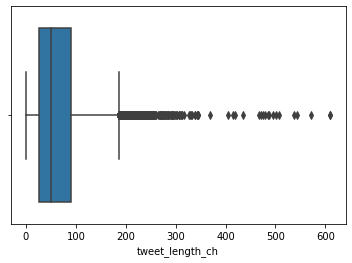

In [ ]:
df['tweet_length_ch']=df['temp_list2'].apply(lambda x:len(x))
sns.boxplot(df['tweet_length_ch'])

> Observation : Most of tweet's lenth are between o to 200 character, having mean of 45 character. But there are also tweets having more range than this.

### Distribution Plots of length

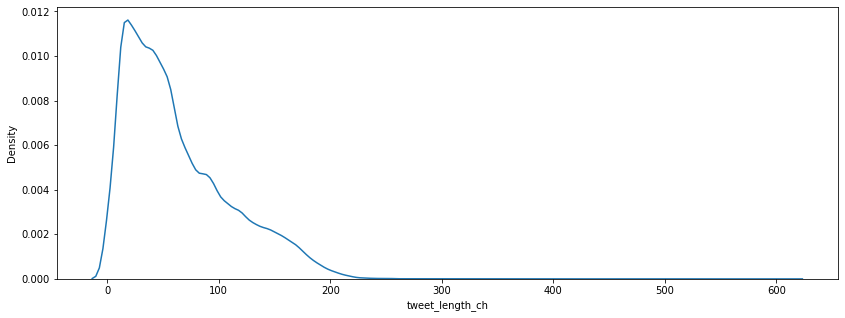

In [ ]:
plt.figure(figsize=(14,5))
length = df['tweet_length_ch']
sns.kdeplot(data=length)

> Observation : Here also, we can see that length of the preprocess tweets has mean approx. 45. 

### Barplot of sentiments counts

  Sentiment   Text
0  Negative  18175
1   Neutral  58755
2  Positive  57432


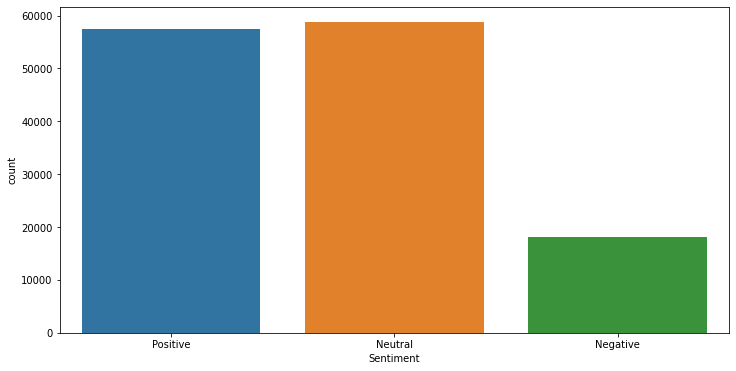

In [ ]:
temp = df.groupby(['Sentiment']).count()['Text'].reset_index()
print(temp)
plt.figure(figsize=(12, 6))
sns.countplot(x='Sentiment', data=df)



> Observation : Neutral Sentiments and positive sentiments are very high in comparision of negative tweets.

### Pie chart of sentiment percentage


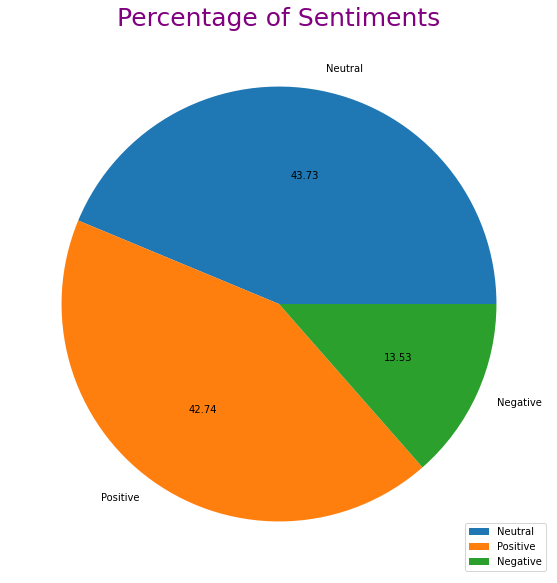

In [ ]:
plt.figure(figsize=(10,10))
ax =df.Sentiment.value_counts()
labels=df['Sentiment'].value_counts().index
plt.pie(ax,labels=labels,autopct='%.2f')
plt.title("Percentage of Sentiments",fontsize=25,color='purple')
plt.legend()
plt.show()

> The percentage of postitive and neutral tweets are almost same, around 43%.

### Most Common Positive Words

In [ ]:
Positive_sent = df[df['Sentiment']=='Positive']
Negative_sent = df[df['Sentiment']=='Negative']
Neutral_sent = df[df['Sentiment']=='Neutral']
top = Counter([item for sublist in Positive_sent['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'Count']
print(temp)
fig = px.bar(temp, x='Count', y='Common_words', title='Most Common Positive Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

   Common_words  Count
0          like   6857
1           get   5317
2          free   3936
3         today   3747
4          good   3552
5           day   3469
6        market   3352
7           buy   3107
8         price   2915
9         share   2831
10          new   2782
11        trade   2739
12         join   2727
13           us   2562
14      support   2552
15        great   2541
16       stocks   2536
17          see   2454
18         time   2433
19          spy   2345


### Most common Negative Words

In [ ]:
top = Counter([item for sublist in Negative_sent['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'Count']
print(temp)
fig = px.bar(temp, x='Count', y='Common_words', title='Most Common Negative Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

   Common_words  Count
0        market   1214
1           buy   1093
2           get   1025
3         today   1012
4           day   1011
5         price    948
6           see    805
7         short    790
8         going    790
9          stop    735
10          one    731
11         time    730
12          new    695
13        still    666
14         like    664
15       people    646
16        money    620
17           go    619
18          bad    612
19           us    594


### Most common neutral words

In [ ]:
top = Counter([item for sublist in Neutral_sent['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'Count']
print(temp)
fig = px.bar(temp, x='Count', y='Common_words', title='Most Common Neutral Words', orientation='h', width=700, height=700, color='Common_words')
fig.show()

      Common_words  Count
0            chart   4183
1        available   2893
2             last   2499
3              buy   2430
4          members   2279
5             hour   2121
6            price   2100
7              say   1984
8              new   1952
9           market   1873
10           today   1787
11       teslawhat   1778
12          charts   1772
13             via   1760
14         viewing   1667
15           group   1609
16  wallstreetbets   1586
17     instruments   1536
18             one   1520
19             day   1470


### Extracting new data frame for total counts

In [ ]:
new_df = pd.DataFrame()
new_df["Date"] = 0
new_df["pos_count"]=0
new_df["neu_count"]=0
new_df["neg_count"]=0
stockname=[]
Date=[]
pos_count=[]
neg_count=[]
neu_count=[]
total_count=[]

for i in range(len(df.Date)-1):
  # i = k -  len(df.Date)
  if df.Date[i] != df.Date[i+1]:
    a = df.Date[i]
    Date.append(a)
    z= df.Stockname[i]
    stockname.append(z)
    b = df.pos_count[i]
    pos_count.append(b)
    c = df.neg_count[i]
    neg_count.append(c)
    d = df.neu_count[i]
    neu_count.append(d)
    e=b+c+d
    total_count.append(e)
new_df["Date"] = Date
new_df["Stockname"] = stockname
new_df["pos_count"]=pos_count
new_df["neu_count"]=neu_count
new_df["neg_count"]=neg_count
new_df["total_count"]=total_count

year=[]
month=[]
day=[]
for i in range(new_df.shape[0]):
  A,B,C = new_df.Date[i].split('-')
  # print(str(df1.iloc[i,0]).split(' ')[0].split('-')[1],'   ', i)
  year.append(A)
  month.append(B)
  day.append(C)
new_df["Year"] = year
new_df["Month"] = month
new_df["Day"] = day
# new_df.drop('Date',axis=1, inplace=True)
new_df = new_df.sort_values(by='Date')
new_df.head()

,Date,pos_count,neu_count,neg_count,Stockname,total_count,Year,Month,Day
1885,2020-01-01,0,0,1,NVDA,1,2020,01,01
1258,2020-01-01,11,7,2,MSFT,20,2020,01,01
628,2020-01-01,9,9,2,AAPL,20,2020,01,01
2388,2020-01-01,1,1,0,PYPL,2,2020,01,01
1257,2020-01-02,7,6,3,MSFT,16,2020,01,02


### Unique words in tweet

In [ ]:
raw_text = [word for word_list in df['temp_list1'] for word in word_list]
def words_unique(sentiment, numwords, raw_text):
    
    allother = []
    for sublist in df[df.Sentiment != sentiment]['temp_list1']:
        for item in sublist:
            allother.append(item)
            
    allother = set(allother)
    
    specificonly = [x for x in raw_text if x not in allother]
    
    word_count = Counter()
    
    for sublist in df[df.Sentiment == sentiment]['temp_list1']:
        for item in sublist:
            word_count[item] += 1
    
    for word in list(word_count):
        if word not in specificonly:
            del word_count[word]
        
    unique_words = pd.DataFrame(word_count.most_common(numwords), columns=['word', 'count'])
    
    return unique_words
unique_negative = words_unique('Negative', 20, raw_text)
print('Top 20 words in negative tweets are:')
unique_negative

Top 20 words in negative tweets are:


,word,count
0,zmjmia,42
1,sosintc,42
2,playmultiplier,40
3,bsl,40
4,xompypllong,40
5,solotlry,36
6,ssl,31
7,tradingesf,31
8,classist,25
9,spycnn,24


Save data in csv's.

In [ ]:
import pandas as pd
import numpy as np
# df.to_csv('/content/twitter_sia.csv')
# new_df.to_csv('/content/twitter_sia_counts.csv')
# df = pd.read_csv("/content/drive/MyDrive/Dipak/Internship/Technocolab/raw_twitter_1.csv")

new_df = pd.read_csv('/content/drive/MyDrive/Dipak/Internship/Technocolab/twitter_sia_counts.csv')
new_df.drop(labels='Unnamed: 0', axis=1, inplace=True)
df1 = df1.astype({'Day': np.int64, "Month": np.int64, "Year":np.int64})
# new_df=twitter_dataframe(df)

### Joining twitter and stock dataset

In [ ]:
df_all = new_df.merge(df1, how='left', on=['Day', 'Month', 'Year','Stockname'])
df_all = df_all[['Date_x','Day','Month','Year','Stockname','pos_count','neu_count','neg_count','total_count','Close','Volume','Open','High','Low']]
df_all = df_all.sort_values(['Year','Month','Day'])

Filling missing value using backward interpolation 

In [ ]:
A = df_all.groupby(by='Stockname')
l1 = ["NVDA","AAPL","MSFT","TSLA","PYPL"]
l2=[ [] for i in range(len(l1)) ]
for i in range(len(l1)):
  l2[i] = A.get_group(l1[i]).interpolate(method='linear', limit_direction='backward')
df_merge = pd.DataFrame()
for i in l2:
  df_merge = df_merge.append(i, ignore_index=True)

Final Dataset

In [ ]:
df_merge['Date_x']=pd.to_datetime(df_merge['Date_x'])
df_merge = df_merge.sort_values(by='Date_x')
# df_merge.to_csv('/content/drive/MyDrive/Dipak/Internship/Technocolab/merged_data.csv')

Plot of Time vs Close price of different Stocks

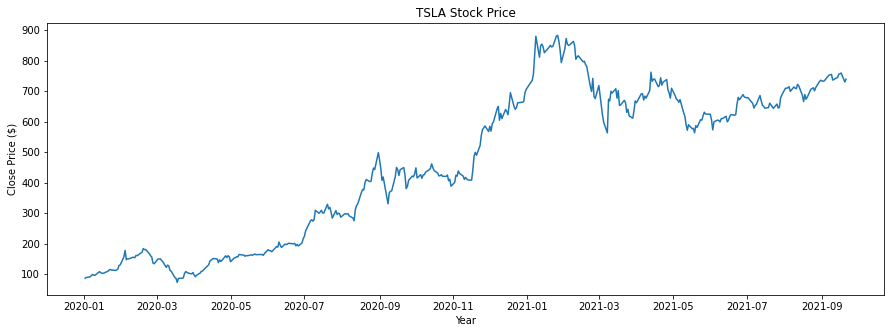

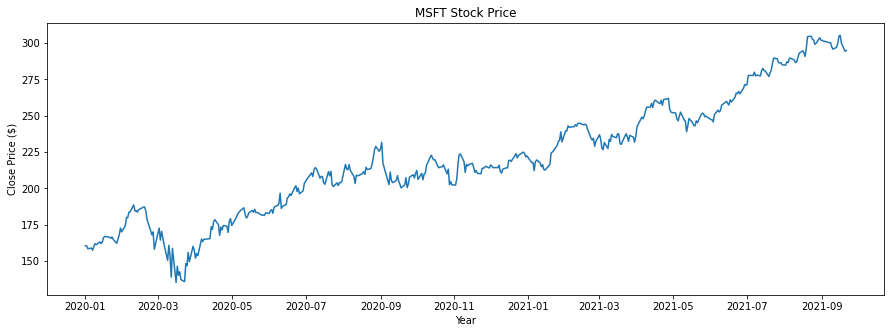

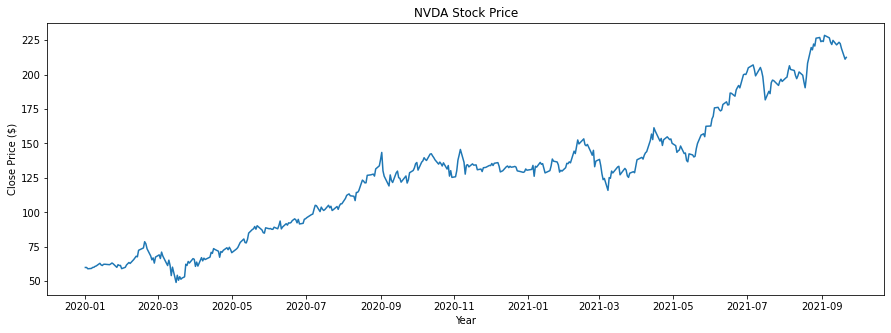

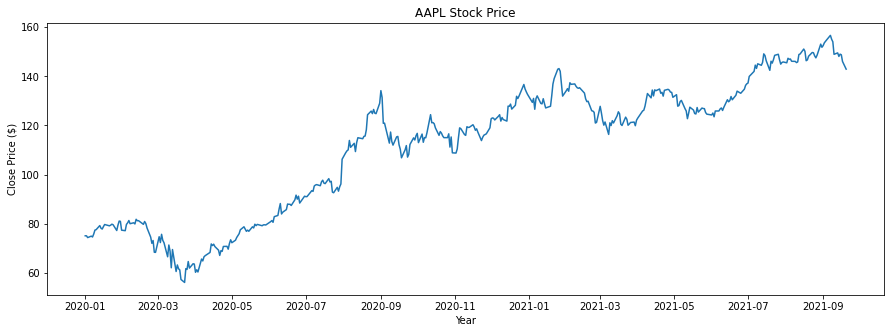

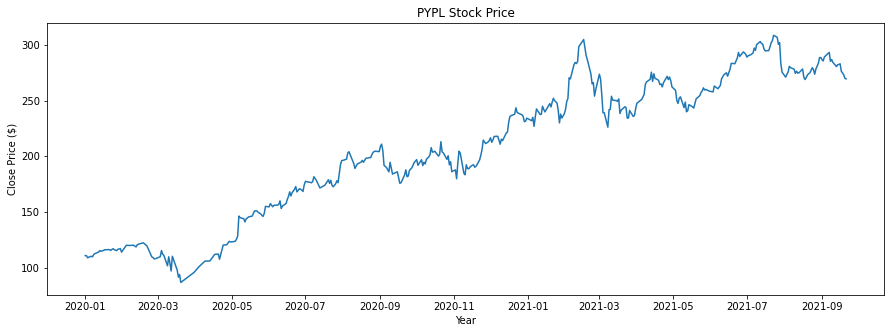

In [ ]:
# The adjusted close accounts for stock splits, so that is what we should graph
A = df_merge.groupby(by='Stockname')


plt.figure(figsize=(15, 5))
plt.plot(A.get_group('TSLA')['Date_x'], A.get_group('TSLA')['Close'])
plt.title('TSLA'+' Stock Price')
plt.xlabel('Year')
plt.ylabel('Close Price ($)');
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(A.get_group('MSFT')['Date_x'], A.get_group('MSFT')['Close'])
plt.title('MSFT'+' Stock Price')
plt.xlabel('Year')
plt.ylabel('Close Price ($)');
plt.figure(figsize=(15, 5))
plt.plot(A.get_group('NVDA')['Date_x'], A.get_group('NVDA')['Close'])
plt.title('NVDA'+' Stock Price')
plt.xlabel('Year')
plt.ylabel('Close Price ($)');
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(A.get_group('AAPL')['Date_x'], A.get_group('AAPL')['Close'])
plt.title('AAPL'+' Stock Price')
plt.xlabel('Year')
plt.ylabel('Close Price ($)');
plt.figure(figsize=(15, 5))
plt.plot(A.get_group('PYPL')['Date_x'], A.get_group('PYPL')['Close'])
plt.title('PYPL'+' Stock Price')
plt.xlabel('Year')
plt.ylabel('Close Price ($)');

> Observation :

>> TSLA : It has highest at Jan-2021 around 900$. But at different interval, either it is increasing rapidly or decresing rapidly.

>> MSFT : It is stadily increasing over the years, and currently in sep 2021, it is highest. Might be because of Windows 11 launch.

>> NVDA : It has increase rapidly after feb 2021, because the use of electronic devices increases in this covid time and also stock might increase over the next few months(years), because currently world is facing the sortage of chips.

>> AAPL : Highest stocks in sep 2021, because of apple 13 launch.

>> PYPL : Decreasing trend after feb 2021.

In [ ]:
# Same code for the ablove plots, but using for loop

# The adjusted close accounts for stock splits, so that is what we should graph
# A = df_merge.groupby(by='Stockname')
# l1 = ["NVDA","AAPL","MSFT","TSLA","PYPL"]
# l2=[ [] for i in range(len(l1)) ]
# for i in range(len(l1)):
#   plt.figure(figsize=(15, 5))
#   plt.plot(A.get_group(l1[i])['Date_x'], A.get_group(l1[i])['Close'])
#   plt.title(l1[i]+' Stock Price')
#   plt.ylabel('Close Price ($)');
#   plt.show()
# # plt.plot(tesla.index, tesla['Adj. Close'], 'r')
# # plt.title('Tesla Stock Price')
# # plt.ylabel('Price ($)');
# # plt.show();

Boxplot of different stocks close price.

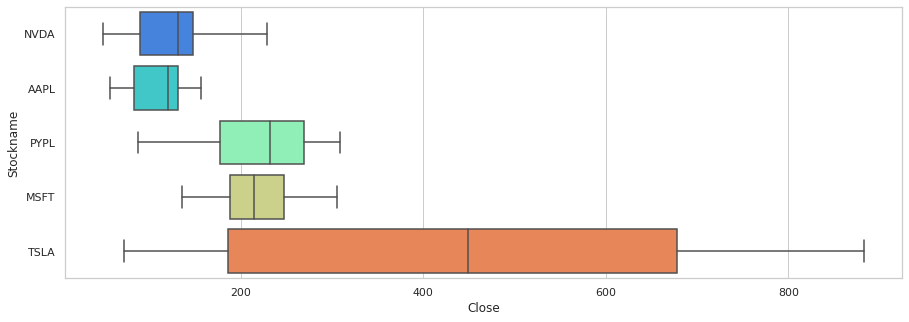

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="Close",y="Stockname",data=df_merge, orient="h", palette="rainbow", ax=ax)
plt.show()

> Observation : TSLA has the most highest closing price over the years, after that PYPL and MSFT are most interesting stocks.

Function

In [ ]:
def data_cleaner():
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import seaborn as sns
  from collections import Counter
  import plotly.express as px
  import os
  import re as re
  import nltk
  from nltk.tokenize import TweetTokenizer
  import string
  nltk.download('stopwords')
  from nltk.corpus import stopwords
  from wordcloud import WordCloud
  nltk.download('vader_lexicon')
  from scipy import sparse
  from nltk.sentiment.vader import SentimentIntensityAnalyzer
  from tqdm import tqdm

  df = data
  def split_date_time(series):
    L1=[]
    L2=[]
    for i in range(len(series)):
      date, time = df["Datetime"][i].split(' ')
      L1.append(date)
      L2.append(time)
    df_1 = pd.DataFrame()
    df_1["Date"] = L1
    df_1["Time"] = L2
    return df_1
  df_1=split_date_time(df["Datetime"])
  df = df.merge(df_1, right_index=True, left_index=True)
  df.drop('Datetime', axis=1, inplace=True)
  df.drop('Time', axis=1, inplace=True)

  def pre_process(df):
    column=df["Text"]
    

    column = column.str.lower()                                                       # Lower Case
    column = column.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))                 # URL links
    column = column.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))       # URL Links
    column = column.apply(lambda x: re.sub(r'{link}', '', x))                         # Placeholders
    column = column.apply(lambda x: re.sub(r"\[video\]", '', x))                      # Placeholders
    column = column.apply(lambda x: re.sub(r'&[a-z]+;', '', x))                       # HTML Functions
    column = column.apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", '', x))      # Non Letters
    column = column.apply(lambda x: re.sub(r'@mention', '', x))                       # Mentions
    column = column.apply(lambda x: re.sub(r'\n', '', x))                             # \n
    column = column.apply(lambda x: re.sub(r'-', '', x))                              # -
    column = column.apply(lambda x: re.sub(r'(\s)#\w+', '', x))                       # remove word starting from hashtag

    

    
    return column
  column=pre_process(df)
  df["clean_text"] = column

  def tokenizer(df):                    
  

    column = df["clean_text"]
    tknzr = TweetTokenizer()
    column = column.apply(tknzr.tokenize)

    PUNCUATION_LIST = list(string.punctuation)
    def remove_punctuation(word_list):
      """Remove punctuation tokens from a list of tokens"""
      return [w for w in word_list if w not in PUNCUATION_LIST]
    df['tokens'] = column.apply(remove_punctuation)
    return df

  df = tokenizer(df)
  nltk.download('stopwords')
  import nltk

  from nltk.corpus import stopwords
  def remove_stopwords(x):
      return [y for y in x if y not in stopwords.words('english')]

  df['temp_list1'] = df['tokens'].apply(lambda x : remove_stopwords(x))

  from nltk.corpus import stopwords as st
  from wordcloud import WordCloud
  st = set('rt')
  st.update(['retweet', 'RT', 'Retweet', 'RETWEET', 'rt', 'plz', 'tsla','tesla','stock','#tsla','elonmusk','apple','#wallstreetbets','reddit','wsbchairman','aapl','#aapl','microsoft'])
  def remove_stopwords(x):
      return [y for y in x if y not in st]

  df['temp_list1'] = df['temp_list1'].apply(lambda x : remove_stopwords(x))

  import nltk
  from nltk.corpus import stopwords
  from wordcloud import WordCloud
  # Create stopword list:
  stopwords = set('rt')
  stopwords.update(['retweet', 'RT', 'Retweet', 'RETWEET', 'rt', 'plz', 'tsla','tesla','stock','#tsla','elonmusk','apple','#wallstreetbets','reddit','wsbchairman','aapl','#aapl','microsoft'])
  l=[]
  for i in df.temp_list1:
    t = " ".join(review for review in i)
    l.append(t)
  df["temp_list2"] = l
  textt = " ".join(review for review in df.temp_list2)

  # Sentiment Analyzer will classify sentiments into positive, negative, and neutral
  sid = SentimentIntensityAnalyzer()
  ss=[]
  for k in tqdm(df.temp_list2):
    # print(k)
    ss.append(sid.polarity_scores(k))
  neg=[]
  pos=[]
  neu=[]
  compound=[]
  for i in tqdm(range(df.temp_list2.shape[0])):
    neg.append(ss[i]["neg"])
    pos.append(ss[i]["pos"])
    neu.append(ss[i]["neu"])
    compound.append(ss[i]["compound"])
  sia_table = pd.DataFrame()
  sia_table["sia_pos"] = pos
  sia_table["sia_neu"] = neu
  sia_table["sia_neg"] = neg
  sia_table["sia_compound"] = compound
  # decide sentiment as positive, negative and neutral
  sentiment=[]
  for i in ss:
    if i['compound'] >= 0.05 :
      sentiment.append("Positive")

    elif i['compound'] <= - 0.05 :
      sentiment.append("Negative")

    else :
      sentiment.append("Neutral")
  df["Sentiment"] = sentiment

  neg=0
  pos=0
  neu=0
  pos_count=[]
  neg_count=[]
  neu_count=[]
  if df.Sentiment[0] == 'Positive':
    pos+=1
    pos_count.append(pos)
    neg_count.append(neg) 
    neu_count.append(neu)
  elif df.Sentiment[0] == 'Negative':
    neg+=1
    pos_count.append(pos)
    neg_count.append(neg) 
    neu_count.append(neu)
  elif df.Sentiment[0] == 'Neutral':
    neu+=1
    pos_count.append(pos)
    neg_count.append(neg) 
    neu_count.append(neu)
  for i in range(1,len(df.Date)):   
    if df.Date[i] == df.Date[i-1]:
      if df.Sentiment[i] == 'Positive':
        pos = pos + 1 
        pos_count.append(pos)
        neg_count.append(neg) 
        neu_count.append(neu)
      elif df.Sentiment[i] == 'Negative':
        neg = neg + 1
        neg_count.append(neg)
        pos_count.append(pos)
        neu_count.append(neu)
      elif df.Sentiment[i] == 'Neutral':
        neu = neu + 1
        neu_count.append(neu)
        neg_count.append(neg)
        pos_count.append(pos)
    elif df.Date[i] != df.Date[i-1]:
      neg=0
      pos=0
      neu=0
      if df.Sentiment[i] == 'Positive':
        pos+=1
        pos_count.append(pos)
        neg_count.append(neg) 
        neu_count.append(neu)
      elif df.Sentiment[i] == 'Negative':
        neg+=1
        pos_count.append(pos)
        neg_count.append(neg) 
        neu_count.append(neu)
      elif df.Sentiment[i] == 'Neutral':
        neu+=1
        pos_count.append(pos)
        neg_count.append(neg) 
        neu_count.append(neu)
    
  df.pos_count = pos_count
  df.neg_count = neg_count
  df.neu_count = neu_count


  new_df = pd.DataFrame()
  new_df["Date"] = 0
  new_df["pos_count"]=0
  new_df["neu_count"]=0
  new_df["neg_count"]=0
  stockname=[]
  Date=[]
  pos_count=[]
  neg_count=[]
  neu_count=[]
  total_count=[]

  for i in range(len(df.Date)-1):
    # i = k -  len(df.Date)
    if df.Date[i] != df.Date[i+1]:
      a = df.Date[i]
      Date.append(a)
      z= df.Stockname[i]
      stockname.append(z)
      b = df.pos_count[i]
      pos_count.append(b)
      c = df.neg_count[i]
      neg_count.append(c)
      d = df.neu_count[i]
      neu_count.append(d)
      e=b+c+d
      total_count.append(e)
  new_df["Date"] = Date
  new_df["Stockname"] = stockname
  new_df["pos_count"]=pos_count
  new_df["neu_count"]=neu_count
  new_df["neg_count"]=neg_count
  new_df["total_count"]=total_count

  year=[]
  month=[]
  day=[]
  for i in range(new_df.shape[0]):
    A,B,C = new_df.Date[i].split('-')
    # print(str(df1.iloc[i,0]).split(' ')[0].split('-')[1],'   ', i)
    year.append(A)
    month.append(B)
    day.append(C)
  new_df["Year"] = year
  new_df["Month"] = month
  new_df["Day"] = day
  # new_df.drop('Date',axis=1, inplace=True)
  new_df = new_df.sort_values(by='Date')
  new_df.head()

  df_all = new_df.merge(df1, how='left', on=['Day', 'Month', 'Year','Stockname'])
  df_all = df_all[['Date_x','Day','Month','Year','Stockname','pos_count','neu_count','neg_count','total_count','Close','Volume','Open','High','Low']]
  df_all = df_all.sort_values(['Year','Month','Day'])

  A = df_all.groupby(by='Stockname')
  l1 = ["NVDA","AAPL","MSFT","TSLA","PYPL"]
  l2=[ [] for i in range(len(l1)) ]
  for i in range(len(l1)):
    l2[i] = A.get_group(l1[i]).interpolate(method='linear', limit_direction='backward')
  df_merge = pd.DataFrame()
  for i in l2:
    df_merge = df_merge.append(i, ignore_index=True)
  
  df_merge['Date_x']=pd.to_datetime(df_merge['Date_x'])
  df_merge = df_merge.sort_values(by='Date_x')

  return df_merge

In [ ]:
data_cleaner()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



NameError: ignored